In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, Input, Conv2D, Flatten, MaxPooling2D
import os
import matplotlib.pyplot as plt
from PIL import Image



## Building Siamese Neural Network Model

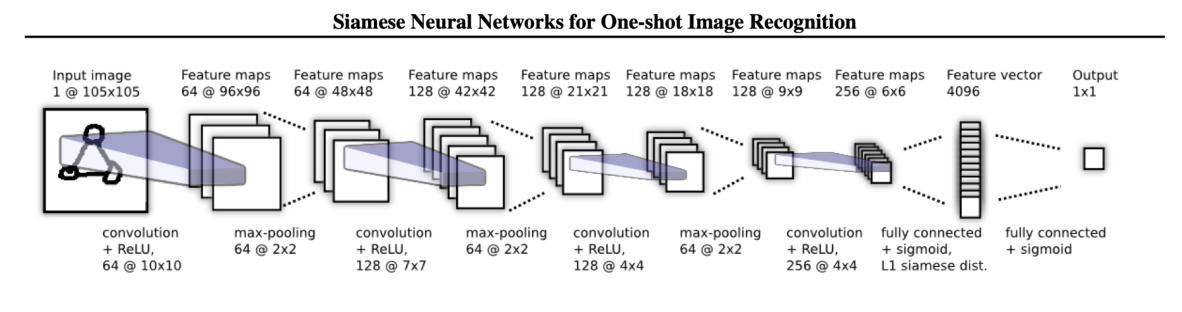

In [2]:
plt.figure(figsize=(15, 20))
plt.imshow(Image.open('/Users/sudipkhadka/Desktop/Face-Recognition/Research/Siamese_architecture.jpg'))
plt.axis('off') 
plt.show()

In [3]:
def embedding():
    inputs = Input(shape=(105, 105, 3), name='input_image')
    layer1 = Conv2D(64, (10, 10), activation='relu')(inputs)
    pool1 = MaxPooling2D(64, (2,2), padding='same')(layer1)

    layer2 = Conv2D(128, (7,7), activation='relu')(pool1)
    pool2 = MaxPooling2D(64, (2,2), padding='same')(layer2)

    layer3 = Conv2D(128, (4,4), activation='relu')(pool2)
    pool3 = MaxPooling2D(64, (2,2), padding='same')(layer3)
    
    layer4 = Conv2D(256, (4,4), activation='relu')(pool3)
    emb = Flatten()(layer4) #flattening into single dimention i.e 6*6*256
    dense = Dense(4096, activation='sigmoid')(emb)
    return Model(inputs=[inputs], outputs=[dense], name='model')

In [4]:
embedding_model = embedding()

In [33]:
embedding_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# now we will build a siamese L1 distance 

class siameseL1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## Build Siamese model

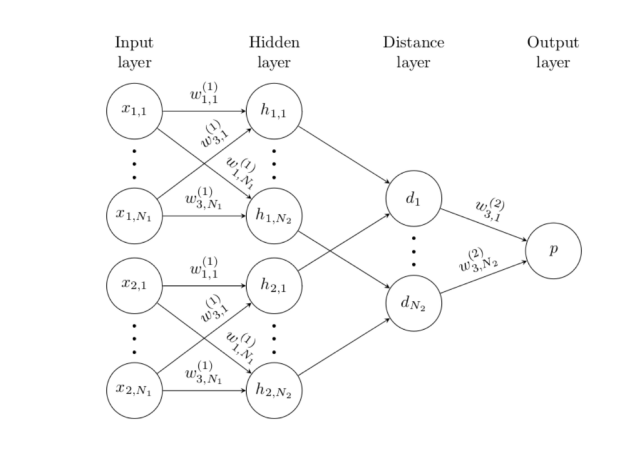

In [24]:
plt.figure(figsize=(8, 10))
plt.imshow(Image.open('/Users/sudipkhadka/Desktop/Face-Recognition/Research/siam_arti.png'))
plt.axis('off') 
plt.show()

In [25]:
#buils Siamese model
def siamese_model():
    input_image = Input(name='input_image', shape=(105,105,3))  #anchor
    validation_image = Input(name='validation_image', shape=(105,105,3)) # positive or negative
    siamses_layer = siameseL1Dist()
    siamses_layer._name = 'distance'
    distance = siamses_layer(embedding_model(input_image), embedding_model(validation_image))
    
    # Clasification layer
    output = Dense(1, activation='sigmoid')(distance)
    return Model(inputs=[input_image, validation_image], outputs=output, name='SiameseNetwork')

In [29]:
siamese_model = siamese_model()

In [30]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model (Functional)  │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│                     │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ siamese_l1_dist_2   │ (1, None, 4096)   │          0 │ model[4][0],      │
│ (siameseL1Dist)     │                   │            │ model[5][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ siamese_l1_dist_… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Training Parameters

In [32]:
binary_cross_entpy = tf.losses.BinaryCrossentropy() 
optimizer = tf.keras.optimizers.Adam(1e-4)

#Establish CheckPoints
checkpoint_directory = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_directory, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)

In [34]:
@tf.function
def train_steps(batch):
    with tf.GradientTape() as tape:
        X = batch[:2] #get anchor and pos or neg image
        y = batch[2] #label

        #define forward pass
        yhat = siamese_model(X, training=True)
        #yhat = tf.reshape(yhat, [-1])
        
        loss = binary_cross_entpy(y, yhat) ##calculate loss

        #Calculate gradient\
    gradiant = tape.gradient(loss, siamese_model.trainable_variables)

        #update weight 
    optimizer.apply_gradient(zip(gradiant, siamese_model.trainable_variables))
    return loss

In [35]:
##Build training loop
def training_loop(data, epochs):
    for epoch in range(1, epochs+1):
        print('/n Epoch {}/{}'.format(epoch, epochs))
        bar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            train_steps(batch)
            progbar.update(idx+1)

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
